# Single Station Models

In [3]:
from obspy import * 
from pandas import *
from os import listdir

import netCDF4 as nc
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Configurations

In [4]:
config = {}

config['workdir'] = "/export/data/LNM/data/"

config['love_phase_nc'] = "PHASE_VELOCITY_MODEL/LovePhaseVelocity.nc"
config['rayleigh_phase_nc'] = "PHASE_VELOCITY_MODEL/RayleighPhaseVelocity.nc"

config['year'] = "2019"
config['datadir_spectra'] = config['workdir']+config['year']+"/"

config['noise_models'] =  config['workdir']+"MODELS/"+"noise_models.npz"

config['spectra_files'] = listdir(config['datadir_spectra'])

config['outdir'] = config['workdir']+"STATS/"

config['period_lower'] = 2.5
config['period_upper'] = 300

config['outdir_figures'] = "/home/brotzer/Documents/ROMY/LowNoiseModel/figures/"


if config['year'] == "2018":
    config['excluded_stations'] = ['KAPI', 'TRQA', 'QSPA', 'FUNA', 'SAML']
elif config['year'] == "2019":
    config['excluded_stations'] = ['KAPI', 'TRQA', 'QSPA', 'FUNA', 'SAML', 'PAYG', 'SDV', 'TSUM']


In [5]:
def __read_velocities_nc(path, fname):
    
    print(f"\nreading {path}{fname}")
    
    f = nc.Dataset(str(path)+str(fname),'r')
    
#     for key in f.variables.keys():
#            print(key)
            
#     print(f.dimensions)          
#     print(f.variables['period'][:])
#     print(f.variables['latitude'][:])
#     print(f.variables['longitude'][:])

    vphase = f.variables['vel'][:]
    # vphase.shape (57, 91, 181)
    # 57 periods: 0.1 to 300 sec 
    # on a grid for lon lat
        
    period = f.variables['period']
    
    return vphase, period

In [6]:
vphase, period = __read_velocities_nc(config["workdir"], config["rayleigh_phase_nc"]);

# vphase, period = __read_velocities_nc(config["workdir"], config["love_phase_nc"]);


reading /export/data/LNM/data/PHASE_VELOCITY_MODEL/RayleighPhaseVelocity.nc


### Calculate Rotation Models for each Station

In [7]:
def __read_spectra_nc(path, fname):
    
    print(f"\nreading {path}{fname}")
    
    f = nc.Dataset(str(path)+str(fname),'r')
    
#     for key in f.variables.keys():
#            print(key)
                    
    sta = f.variables["trace_id"][:][0].split(".")[1]
    ff = f.variables["frequency"][:]
    ss = f.variables["spectrogram"][:]
    lon = float(f.variables["lon"][:].data)
    lat = float(f.variables["lat"][:].data)
    
    return sta, ff, ss, lon, lat

In [8]:
def __get_velocity_profile(vdata, period, lat, lon, mode="nearest", plot=False):

    from numpy import sqrt
    
    if mode is "nearest":
        velocity_profile =  vdata[:,round(lat),round(lon)]

    if mode is "inverse_distance":
        
        def __get_distance(lat_p1,lon_p1, lat_p2,lon_p2):
            return sqrt((lat_p1-lat_p2)**2 + (lon_p1-lon_p2)**2)
            
        lon1, lon2 = int(np.ceil(lon)), int(np.floor(lon))
        lat1, lat2 = int(np.ceil(lat)), int(np.floor(lat))

        lon_w1, lon_w2 = abs(lon1-lon), abs(lon2-lon)
        lat_w1, lat_w2 = abs(lat1-lat), abs(lat2-lat)

        v1 = vphase[:,lat1,lon1]
        v2 = vphase[:,lat2,lon1]
        v3 = vphase[:,lat2,lon2]
        v4 = vphase[:,lat1,lon2]
        
        d1 = __get_distance(lat, lon, lat1, lon1)
        d2 = __get_distance(lat, lon, lat2, lon1)
        d3 = __get_distance(lat, lon, lat2, lon2)
        d4 = __get_distance(lat, lon, lat1, lon2)
        
        velocity_profile = (v1*d1 + v2*d2 + v3*d3 + v4*d4)/(d1+d2+d3+d4)

        if plot:
            plt.plot(period, v1,label="v1")
            plt.plot(period, v2,label="v2")
            plt.plot(period, v3,label="v3")
            plt.plot(period, v4,label="v4")
            plt.plot(period, vv, 'k',label="interp")
            plt.legend()
            plt.show();
        
    return velocity_profile

In [9]:
def __get_stats(arr, axis=0):

    med, men, std = [],[],[]
    nan_found = False

    for fcross in range(arr.shape[axis]):
        if axis == 0:
            data = arr[fcross,:]
        elif axis == 1:
            data = arr[:,fcross]
        if np.isnan(data).any():
            nan_found = True
            data = data[~np.isnan(data)]
        men.append(np.mean(data))
        med.append(np.median(data))
        std.append(np.std(data))

    if nan_found:
        print(" -> NaN values were detected and ignored!")

    return np.array(med), np.array(men), np.array(std)

In [10]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero, zeros
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [11]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [12]:
def __get_minimum_psd(psds):
            
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = psd.sum()
            idx = 0

        value = psd.sum() 
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i   
    
    return psds[idx]

In [26]:
def __get_percentiles(arr):
    
    from numpy import zeros, nanpercentile, shape
    
    percentiles_lower = zeros(shape(arr)[1])
    percentiles_upper = zeros(shape(arr)[1])

    for kk in range(shape(arr)[1]):
        out = nanpercentile(arr[:, kk],  [5,95])
        percentiles_upper[kk] = out[1]
        percentiles_lower[kk] = out[0]
        
    return percentiles_lower, percentiles_upper

The median of each station and the appropriate velocity profile is used to compute rotation spectra

In [14]:
path = config['datadir_spectra']

# files = ["ESACCI-SEASTATE-L2-MSSPEC-IU_YAK_LHZ_00_2018-fv01.nc"]
files = config['spectra_files']

sta_med = DataFrame()
rot_med  = DataFrame()
rot_mini = DataFrame()

for n, file in enumerate(files[:]):
    
    ## read station spectra
    sta, ff, ss, lon, lat = __read_spectra_nc(path, file)
    
    ## skip corrupt stations
    if sta in config['excluded_stations']:
        print(f" -> ignoring {sta}")
        continue

    ## add periods to dataframe
    if n == 0:
        pp = 1/ff
        rot_med['period'] = 1/ff
        rot_mini['period'] = 1/ff
        sta_med['period'] = 1/ff
        
    ## get velocity profile of station
    vv = __get_velocity_profile(vphase, period, lat, lon, mode="inverse_distance", plot=False)
    
    ## interpolate and convert (km/s -> m/s) velocity profile
    vv_interp = np.interp(pp, period[:], vv) * 1000    
    
    ## get statistics of spectra
    med, men, std = __get_stats(ss, axis=0)    
    sta_med[sta] = med
    
    ## get minimal spectrum
    mini = __get_minimal_psd(ss.transpose())
    
    ## compute rotation
    rot_med[sta]  = np.array(np.sqrt(med)  / vv_interp)
    rot_mini[sta] = np.array(np.sqrt(mini) / vv_interp)



reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_GNI_LHZ_10_2019-fv01.nc
 -> NaN values were detected and ignored!

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_NWAO_LHZ_10_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_BBSR_LHZ_00_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_MA2_LHZ_00_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_COLA_LHZ_10_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_FURI_LHZ_00_2019-fv01.nc
 -> NaN values were detected and ignored!

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_GUMO_LHZ_10_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-G_ECH_LHZ_00_2019-fv01.nc
 -> NaN values were detected and ignored!

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_JOHN_LHZ_00_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_BIL


reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_PAYG_LHZ_10_2019-fv01.nc
 -> ignoring PAYG

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_SLBS_LHZ_10_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-II_KWJN_LHZ_00_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_KBS_LHZ_00_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_PTCN_LHZ_10_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_PTCN_LHZ_00_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-II_DGAR_LHZ_00_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_QSPA_LHZ_70_2019-fv01.nc
 -> ignoring QSPA

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-G_COYC_LHZ_00_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-G_SSB_LHZ_00_2019-fv01.nc
 -> NaN values were detected and ignored!

reading /export/data/LNM/


reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-II_FFC_LHZ_00_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_TARA_LHZ_10_2019-fv01.nc
 -> NaN values were detected and ignored!

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-II_KWJN_LHZ_10_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-G_FUTU_LHZ_00_2019-fv01.nc
 -> NaN values were detected and ignored!

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_SSPA_LHZ_10_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-G_SPB_LHZ_00_2019-fv01.nc
 -> NaN values were detected and ignored!

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_KONO_LHZ_00_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_PET_LHZ_10_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-G_WUS_LHZ_00_2019-fv01.nc

reading /export/data/LNM/data/2019/ESACCI-SEASTATE-L2-MSSPEC-IU_SDV_LH

## Velocity Profiles for FUR and WET

In [15]:
# lat_fur, lon_fur =  48.16,  11.28
# lat_wet, lon_wet =  49.14,  12.88

# vv_fur = __get_velocity_profile(vphase, period, lat_fur, lon_fur, mode="inverse_distance", plot=False)
# vv_wet = __get_velocity_profile(vphase, period, lat_wet, lon_wet, mode="inverse_distance", plot=False)

# vv_fur2 = __get_velocity_profile(vphase, period, lat_fur, lon_fur, mode="nearest", plot=False)
# vv_wet2 = __get_velocity_profile(vphase, period, lat_wet, lon_wet, mode="nearest", plot=False)

# # vv_fur_interp = np.interp(1/ff, period[:], vv_fur) * 1000
# # vv_wet_interp = np.interp(1/ff, period[:], vv_wet) * 1000

# vv_fur_wet = DataFrame()

# vv_fur_wet['periods'] = period[:]
# vv_fur_wet['vv_fur'] = vv_fur
# vv_fur_wet['vv_wet'] = vv_wet

# import pickle

# pickle.dump(vv_fur_wet, open("/export/data/LNM/data/PHASE_VELOCITY_MODEL/"+"fur_wet_rayleigh.pkl",'wb'))


# plt.figure(figsize=(15,5))
# plt.semilogx(period[:], vv_fur)
# plt.semilogx(period[:], vv_wet)
# plt.semilogx(period[:], vv_fur2)
# plt.semilogx(period[:], vv_wet2)
# plt.show();

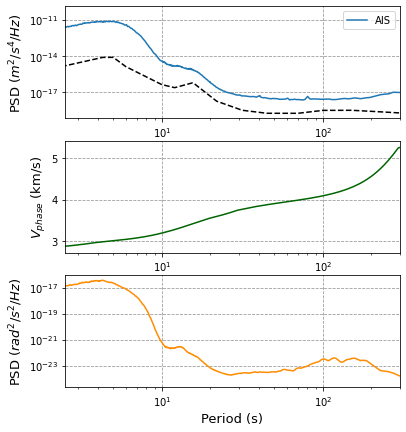

In [16]:
tmp = np.load(config['noise_models'])
nm_periods, nlnm, nhnm = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

test_station = 'AIS'

font = 13

fig, ax = plt.subplots(3,1,figsize=(6,7))

ax[0].plot(pp, med, label=test_station)
ax[0].plot(nm_periods, 10**(nlnm/10), color="k", ls="--")
ax[0].set_ylabel(r"PSD $(m^2/s^4 /Hz)$", fontsize=font)
ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(pp, vv_interp/1e3, color="darkgreen")
ax[1].set_ylabel(r"$V_{phase}$ (km/s)", fontsize=font)

ax[2].plot(pp,rot_med[test_station]**2, color="darkorange")
ax[2].set_ylabel(r"PSD $(rad^2/s^2 /Hz)$", fontsize=font)
ax[2].set_yscale("log")
ax[2].set_xlabel("Period (s)", fontsize=font)

for i in range(3):
    ax[i].set_xlim(2.5, 300)
    ax[i].set_xscale("log")
    ax[i].grid(color="grey", alpha=0.8, ls="--", zorder=0)
    
fig.show();

### Write to File

In [17]:
# rot_med.to_pickle(config['outdir']+"2018_rotations_spectra_median.pkl")

# rot_mini.to_pickle(config['outdir']+"2018_rotations_spectra_minimals.pkl")

### Plot Rotation Model from Station Data

In [18]:
rot_psds = np.array([rot_med[sta] for sta in rot_med.keys() if sta is not 'period' and sta.split(".")[0] not in config['excluded_stations']])

pp = rot_med['period']

In [19]:
def __conversion(data, informat=None, outformat=None):
    '''
    data:                  array 
    informat/outformat:    ASD, PSD, DB
    '''
    from numpy import log10, sqrt
    
    
    if informat == 'ASD' and outformat == 'PSD':
        return data**2
    
    elif informat == 'PSD' and outformat == 'ASD':
        return sqrt(data)

    elif informat == 'ASD' and outformat == 'DB':
        return 20*log10(data)
    
    elif informat == 'PSD' and outformat == 'DB':
        return 10*log10(data)
    
    elif informat == 'DB' and outformat == 'PSD':
        return 10**(data/10)
    
    elif informat == 'DB' and outformat == 'ASD':
        return sqrt(10**(data/10))
    
    else:
        print(" -> specified case not defined!")

In [20]:
rot_psds_db = __conversion(rot_psds, informat='ASD', outformat='DB')

In [21]:
def __calculate_density_new(psd_array, bins=20, density=False, axis=1):

    from numpy import argmax, std, median, isnan, array, histogram, nan, zeros, count_nonzero, log10, isinf
    from scipy.stats import median_abs_deviation as mad
    
    def __convert_to_log(in_psds):

        print(in_psds.shape)

        out_psds = np.zeros(in_psds.shape)
        rows_with_zeros = 0
        for i, psd in enumerate(in_psds):
            if np.count_nonzero(psd) != len(psd):
                rows_with_zeros +=1
                psd = [nan for val in psd if val == 0]
            out_psds[i,:] = np.log10(psd)
            if np.isinf(out_psds[i,:]).any():
                out_psds[i,:] = nan * ones(len(out_psds[i,:]))

        return out_psds

#     psd_array = __convert_to_log(psd_array)

    print(f"total spectra used: {psd_array.shape[0]}")

    for m in range(psd_array.shape[0]):
        plt.plot(psd_array[m,:])
    
    ## exclude psds with only NaN values
    psds = array([psd for psd in psd_array if not isnan(psd).all()])

    
    ## find overall minimum and maxium values
    max_value = max([max(sublist) for sublist in psd_array if np.isfinite(sublist).all()])
    min_value = min([min(sublist) for sublist in psd_array if np.isfinite(sublist).all()])
    print(min_value, max_value)

    ## define empty lists
    dist, dist_maximas, bins_maximas, bins_medians, stds, mads = [], [], [], [], [], []
    
    count = 0
    for h in range(len(psd_array[axis])):
        
        psd = psd_array[:,h]
        
        ## compute histograms
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);
                
        ## center bins
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        ## normalization
#         if  True:
#             hist = [val / len(psd_array[:,h]) for val in hist]
#             config['set_density'] = True

        ## check if density works
        DX = abs(max_value-min_value)/bins
        SUM = sum(hist)
        if str(SUM*DX) != "1.0":
            count+=1
        
        ## modify histogram with range increment
        hist = hist*DX
        
        ## append values to list
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        mads.append(mad(hist)) 
        
        ## compute median
        psd = psd[~(isnan(psd))]
        bins_medians.append(median(psd[psd != 0]))

    ## undo log conversion    
#     output = {}
#     output['dist'] = array(dist)
#     output['bin_mids'] = 10**array(bin_mids)
#     output['bins_maximas'] = 10**array(bins_maximas)
#     output['stds'] = 10**array(stds)
#     output['mads'] = 10**array(mads)
#     output['bins_medians'] = 10**array(bins_medians)
#     output['set_density'] = density
#     output['total'] = psd_array.shape[0]
    
    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = array(bin_mids)
    output['bins_maximas'] = array(bins_maximas)
    output['stds'] = array(stds)
    output['mads'] = array(mads)
    output['bins_medians'] = array(bins_medians)
    output['set_density'] = density
    output['total'] = psd_array.shape[0]
    
    if count > 0:
        print(f" {count} errors found for density computation!!!")
    
    return output

total spectra used: 119
-267.737298033 -158.456396645


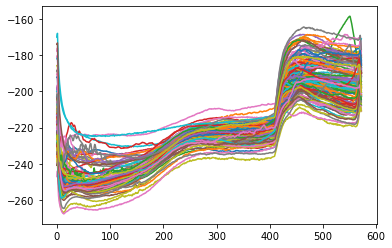

In [22]:
output = __calculate_density_new(rot_psds_db, bins=100, density=True)

In [23]:
def __makeplot_PPSD_new(xx, output, config, mode=None, plot_noise_models=False):

    from matplotlib import colors
    from numpy import ones, convolve, array, log10, roll, sqrt

    tmp = np.load(config['noise_models'])
    nm_periods, nlnm, nhnm = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

    bins, bins_medians, bins_maximas, dist = output['bin_mids'], output['bins_medians'], output['bins_maximas'], output['dist']
    
    
    if mode == "PSD":
        y_axis = 10**(bins/10)
        medians = 10**(bins_medians/10)
        ymin, ymax = 1e-26, 1e-20
    elif mode == "ASD":
        y_axis = 10**(bins/20)
        medians = 10**(bins_medians/20)
        ymin, ymax = 1e-13, 1e-10
    elif mode == "DB":
        y_axis = bins
        medians = bins_medians
        ymin, ymax = -300, -180

    x_axis = 1/xx

    ## plotting
    fig, ax = plt.subplots(1,1,figsize=(13,6))

    font=14

    cmap = plt.cm.get_cmap('magma_r')
#     cmap = plt.cm.get_cmap('gray_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, dist.T, 
                    cmap=cmap,
                    vmin=1e-12, 
                    alpha=0.99,
                   )

    ## add Frequency Axis
    g = lambda x: 1/x
    ax2 = ax.secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency in Hz", fontsize=font, labelpad=5)
    ax2.set_xticklabels(1/xx, fontsize=11)    
    

    
    x_axis_mod = x_axis + (np.roll(x_axis,-1)-x_axis)/2; x_axis_mod[-1] = x_axis[-1] + (x_axis[-1]-x_axis[-2])/2

    ## medians
    plt.plot(x_axis_mod, medians, color='black', alpha=0.8, label="median")
    
    ## maximas
#     plt.plot(x_axis_mod, maximas, color='black', alpha=0.8, label="RNLM")


    if mode is not "DB":
        plt.yscale("log")
    

    ## modify x-axis
    plt.xscale('log')
    plt.xlim([min(x_axis), max(x_axis)])

    plt.xlim(2.5, 300)
#     plt.fill_betweenx(range(ymin, ymax), x1=0, x2=2.5, color="grey", alpha=0.4)
#     plt.fill_betweenx(range(ymin, ymax), x1=200, x2=max(ff), color="grey", alpha=0.4)
        
    ## add colorbar
    caxes = fig.add_axes()
    cb = plt.colorbar(im, cax=caxes, alpha=1.0)
    
    if output['set_density']:
        cb.set_label("Propability Density", fontsize=font)
    else:
        cb.set_label("Counts", fontsize=font)
        cb.set_label("Propability Density", fontsize=font)
    
    if mode is "DB":
#         plt.ylabel(r"PPSD in dB (rel. to 1 m$^4$/s$^2$/$Hz$)", fontsize=font)
        plt.ylabel(r"PPSD in dB (rel. to 1 rad$^2$/s$^2$/$Hz$)", fontsize=font)
    elif mode is "PSD":
#         plt.ylabel(r"PPSD in m$^4$/s$^2$/$Hz$", fontsize=font)
        plt.ylabel(r"PPSD in $\frac{rad^2}{s^2 Hz}$", fontsize=font)
    elif mode is "ASD":
        plt.ylabel(r"PASD in $\frac{rad}{s \sqrt{Hz}}$", fontsize=font)
        
    plt.grid(axis="both", which="both", ls="--", zorder=0)
    plt.legend()
    
    plt.xlabel("Period in seconds", fontsize=font)

    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

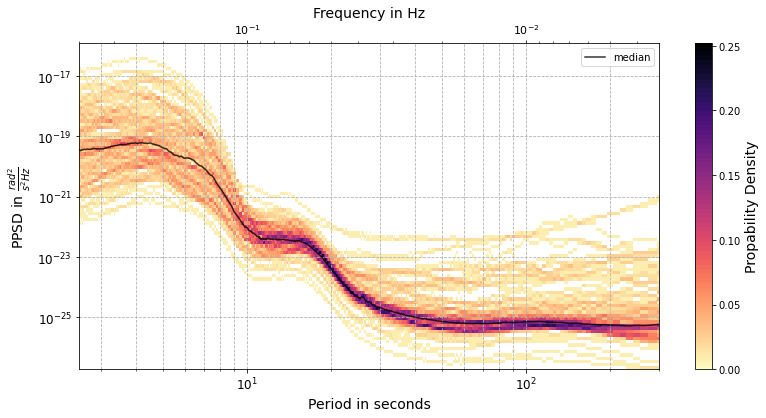

In [24]:
fig = __makeplot_PPSD_new(ff, output, config, mode="PSD", plot_noise_models=False)

In [63]:
# fig.savefig(config['outdir_figures']+f"RLNM_single_stations_{config['year']}_PSD"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

## Write to File

In [28]:
df_out = DataFrame()

df_out['period'] = pp
# df_out['median'] = output['bins_medians']
df_out['median'] = __get_median_psd(rot_psds)
df_out['minimal'] = __get_minimal_psd(rot_psds)
df_out['minimum'] = __get_minimum_psd(rot_psds)
df_out['perc_lower'] = __get_percentiles(rot_psds)[0]
df_out['perc_upper'] = __get_percentiles(rot_psds)[1]


outname = f"station_{config['year']}_derived_rlnm.pkl"
df_out.to_pickle(config['outdir']+outname)
print(f" -> writing to {config['outdir']}{outname}")

 -> writing to /export/data/LNM/data/STATS/station_2019_derived_rlnm.pkl


## Plot Overview of Station PSD

In [65]:
sta_psds = np.array([sta_med[sta] for sta in sta_med.keys() if sta is not 'period' and sta.split(".")[0] not in config['excluded_stations']])

pp = sta_med['period']

In [66]:
def __calculate_density2(psd_array, bins=20, density=False, axis=1):

    from numpy import argmax, std, median, isnan, array, histogram, nan
    from scipy.stats import median_abs_deviation as mad
    
    def __convert_to_log(in_psds):

        print(in_psds.shape)

        out_psds = np.zeros(in_psds.shape)
        rows_with_zeros = 0
        for i, psd in enumerate(in_psds):
            if np.count_nonzero(psd) != len(psd):
                rows_with_zeros +=1
                psd = [nan for val in psd if val == 0]
            out_psds[i,:] = np.log10(psd)
            if np.isinf(out_psds[i,:]).any():
                out_psds[i,:] = nan * ones(len(out_psds[i,:]))

        return out_psds

    psd_array = __convert_to_log(psd_array)
    
    print(f"total spectra used: {psd_array.shape[0]}")
    
    ## exclude psds with only NaN values
    psds = array([psd for psd in psd_array if not isnan(psd).all()])

    
    ## find overall minimum and maxium values
    max_value = max([max(sublist) for sublist in psd_array])
    min_value = min([min(sublist) for sublist in psd_array])
#     print(min_value, max_value)

    ## define empty lists
    dist, dist_maximas, bins_maximas, bins_medians, stds, mads = [], [], [], [], [], []
    
    count = 0
    for h in range(len(psd_array[axis])):
        
        psd = psd_array[:,h]
        
        ## compute histograms
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);
                
        ## center bins
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        ## normalization
#         if  True:
#             hist = [val / len(psd_array[:,h]) for val in hist]
#             config['set_density'] = True

        ## check if density works
        DX = abs(max_value-min_value)/bins
        SUM = sum(hist)
        if str(SUM*DX) != "1.0":
            count+=1
        
        ## modify histogram with range increment
        hist = hist*DX
        
        ## append values to list
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        mads.append(mad(hist)) 
        
        ## compute median
        psd = psd[~(isnan(psd))]
        bins_medians.append(median(psd[psd != 0]))

    ## undo log conversion    
    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = 10**array(bin_mids)
    output['bins_maximas'] = 10**array(bins_maximas)
    output['stds'] = 10**array(stds)
    output['mads'] = 10**array(mads)
    output['bins_medians'] = 10**array(bins_medians)
    output['set_density'] = density
    output['total'] = psd_array.shape[0]
    
    if count > 0:
        print(f" {count} errors found for density computation!!!")
    
    return output

In [67]:
output = __calculate_density2(sta_psds, bins=100, density=True)

(119, 573)
total spectra used: 119


In [68]:
def __makeplot_PPSD2(ff, output, config, mode=None, plot_noise_models=False):

    from matplotlib import colors
    from numpy import ones, convolve, array, log10, roll, sqrt

    tmp = np.load(config['noise_models'])
    nm_periods, nlnm, nhnm = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

    bins, bins_medians, bins_maximas, dist = output['bin_mids'], output['bins_medians'], output['bins_maximas'], output['dist']
    
    if mode is "DB":
        y_axis = 10*log10(bins)
    elif mode is "PSD":
        y_axis = bins
    elif mode is "ASD":
        y_axis = sqrt(bins)
        
    x_axis = ff

    ## plotting
    fig, ax = plt.subplots(1,1,figsize=(13,6))

    font=14

    cmap = plt.cm.get_cmap('magma_r')
#     cmap = plt.cm.get_cmap('gray_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, dist.T, 
                    cmap=cmap,
                    vmin=1e-12, 
                    alpha=0.99,
                   )

    ## add Frequency Axis
    g = lambda x: 1/x
    ax2 = ax.secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency in Hz", fontsize=font, labelpad=5)
    ax2.set_xticklabels(1/ff, fontsize=11)    
    
    
    if mode is "DB":
        plt.plot(x_axis, 10*log10(bins_medians), color='black', alpha=0.8, label="RNLM")
        if plot_noise_models:
            plt.plot(nm_periods, nlnm, color='black', alpha=0.8, ls="--")
            plt.plot(nm_periods, nhnm, color='black', alpha=0.8, ls="--")      
            plt.ylim(-200, -80)
#             plt.ylim(-270, -150)

    elif mode is "PSD":
        plt.plot(x_axis, bins_medians, color='black', alpha=0.8, label="median")
        plt.yscale('log')
        plt.ylim(10**-19, 10**-9)
        if plot_noise_models:
            plt.plot(nm_periods, 10**(nlnm/10), color='black', alpha=0.8, ls="--")
            plt.plot(nm_periods, 10**(nhnm/10), color='black', alpha=0.8, ls="--")
            
    elif mode is "ASD":  
        plt.plot(x_axis, sqrt(bins_medians), color='black', alpha=0.8, label="RNLM")
        plt.yscale('log')
        plt.ylim(10**-14, 2*10**-8)
        if plot_noise_models:
            plt.plot(nm_periods, 10**(nlnm/10), color='black', alpha=0.8, ls="--")
            plt.plot(nm_periods, 10**(nhnm/10), color='black', alpha=0.8, ls="--")    

    
#     plt.fill_betweenx(range(-270, -140), x1=0, x2=2.5, color="grey", alpha=0.4)
#     plt.fill_betweenx(range(-270, -140), x1=200, x2=max(ff), color="grey", alpha=0.4)

    ## modify x-axis
    plt.xscale('log')
#     plt.xlim([min(x_axis), max(x_axis)])
    plt.xlim(2.5, 200)
    
    ## add colorbar
    caxes = fig.add_axes()
    cb = plt.colorbar(im, cax=caxes, alpha=1.0)
    
    if output['set_density']:
        cb.set_label("Propability Density", fontsize=font)
    else:
        cb.set_label("Counts", fontsize=font)
        cb.set_label("Propability Density", fontsize=font)
    
    if mode is "DB":
        plt.ylabel(r"PPSD in dB (rel. to 1 m$^4$/s$^2$/$Hz$)", fontsize=font)
#         plt.ylabel(r"PPSD in dB (rel. to 1 rad$^2$/s$^2$/$Hz$)", fontsize=font)
    elif mode is "PSD":
        plt.ylabel(r"PPSD in m$^2$/s$^4$/$Hz$", fontsize=font)
#         plt.ylabel(r"PPSD in $\frac{rad^2}{s^2 Hz}$", fontsize=font)
    elif mode is "ASD":
        plt.ylabel(r"PPSD in m/s$^2$/$\sqrt{Hz}$", fontsize=font)
#         plt.ylabel(r"PASD in $\frac{rad}{s \sqrt{Hz}}$", fontsize=font)
        
#     plt.grid(axis="both", which="both", ls="--", zorder=0)
    plt.legend()
    
    plt.xlabel("Period in seconds", fontsize=font)

    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

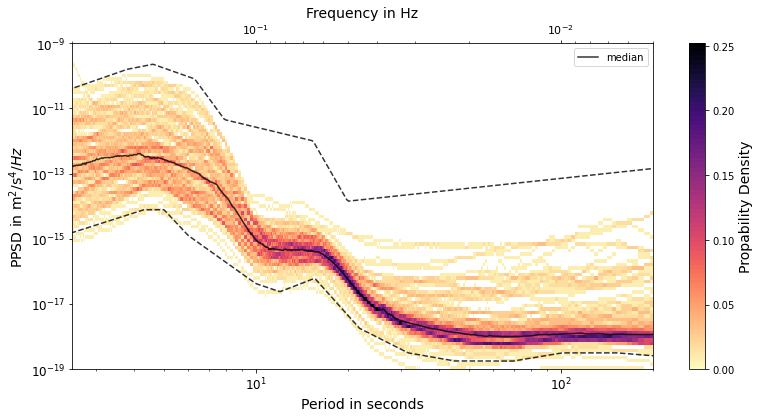

In [69]:
fig = __makeplot_PPSD2(pp, output, config, mode="PSD", plot_noise_models=True)

In [70]:
fig.savefig(config['outdir_figures']+"PPSD_all_stations_"+config['year']+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

## Others

In [ ]:
y_db = __conversion(output['bins_medians'], informat='PSD', outformat='DB')
std_db = __conversion(output['stds'], informat='PSD', outformat='DB')

y_upper = y_db + std_db
y_lower = y_db - std_db

plt.figure(figsize=(15,5))

plt.plot(pp, y_db) 
plt.fill_between(pp, y1=y_lower, y2=y_upper, color="grey", alpha=0.5)


plt.fill_betweenx(range(-260, -170), x1=0, x2=2.5, color="grey", alpha=0.4)
plt.fill_betweenx(range(-260, -170), x1=200, x2=max(pp), color="grey", alpha=0.4)

plt.xscale("log")

plt.ylim(-260,-180)
# plt.xlim(2.5, 200)
# plt.yscale("log")

TAU


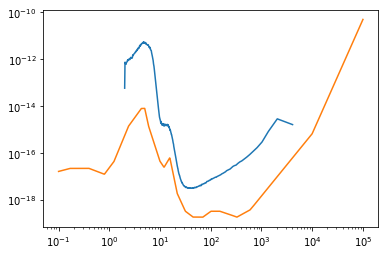

SSPA


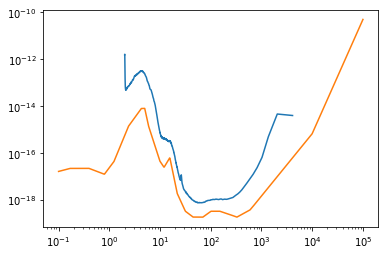

TARA


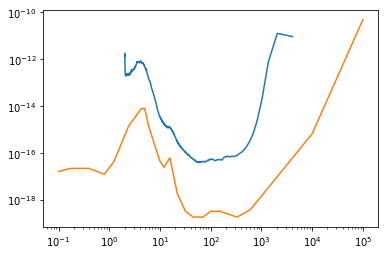

WAKE


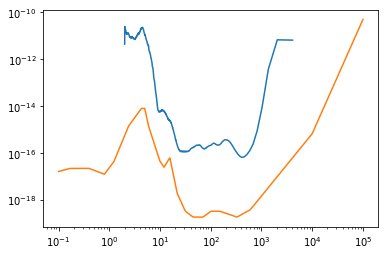

RPN


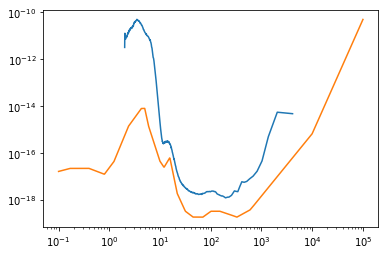

XMAS


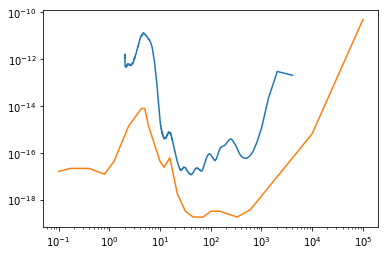

SFJD


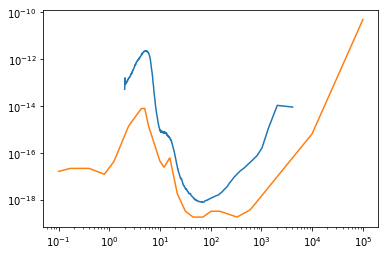

JTS


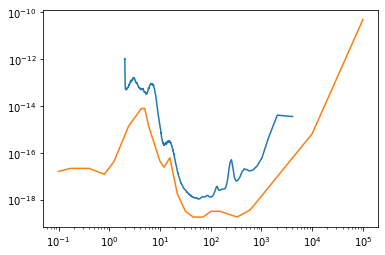

FFC


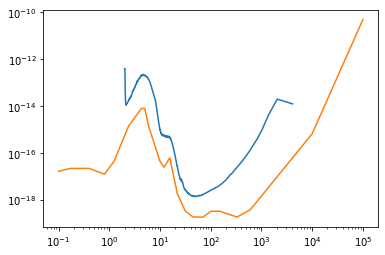

EFI


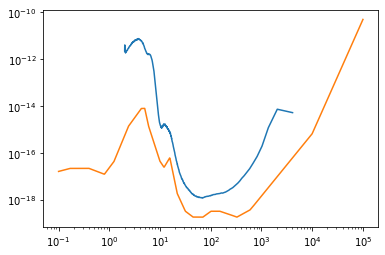

TIXI


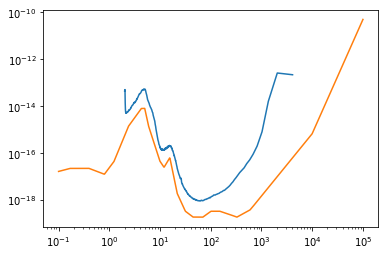

MAKZ


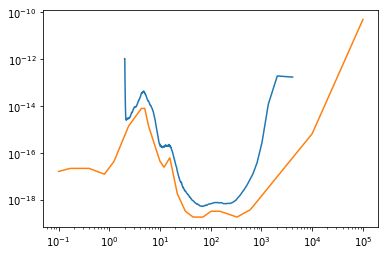

CHTO


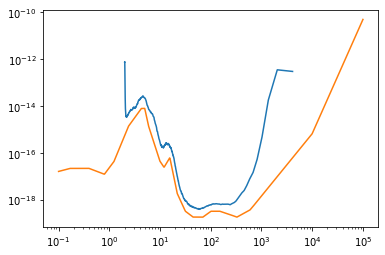

UNM


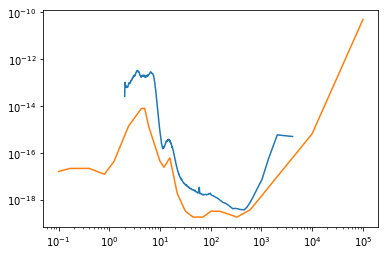

PAB


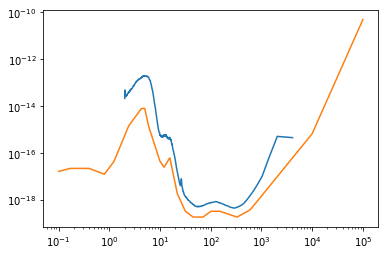

COCO


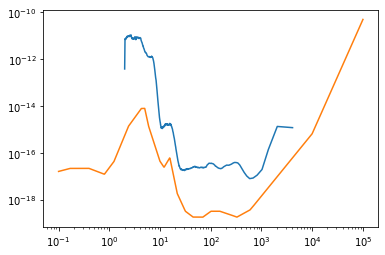

XPFO


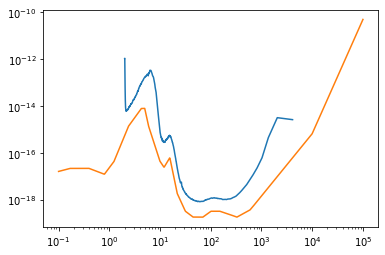

CCM


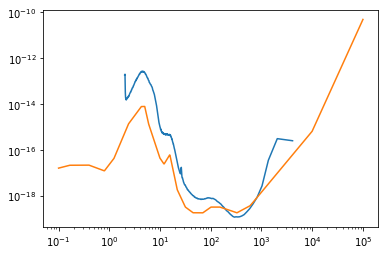

KONO


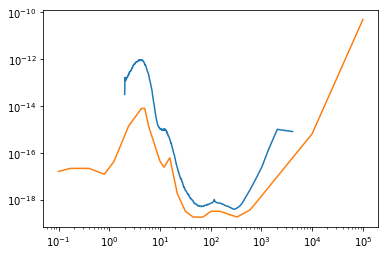

MA2


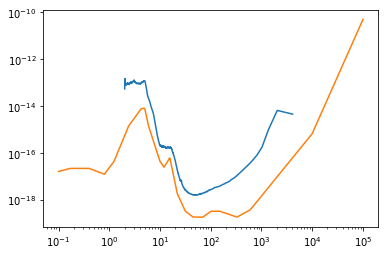

MBO


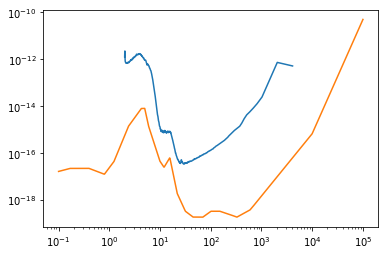

HRV


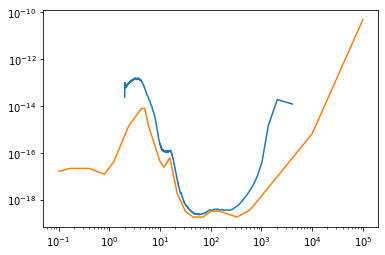

PMG


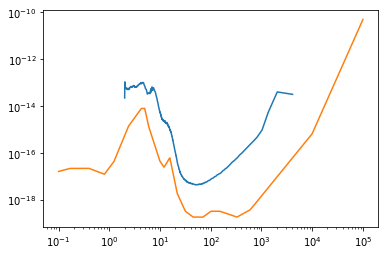

COLA


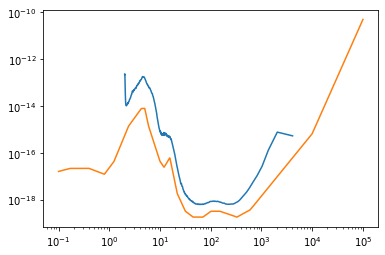

AFI


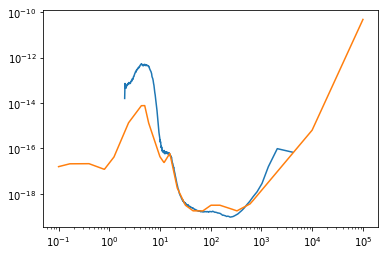

JOHN


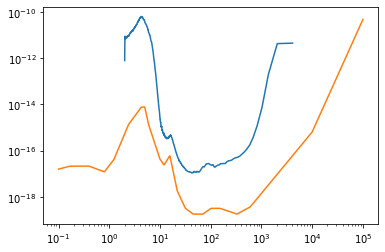

SLBS


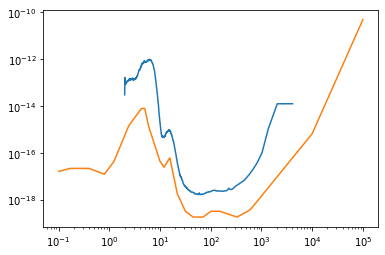

KMBO


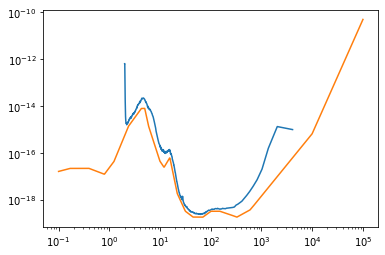

GUMO


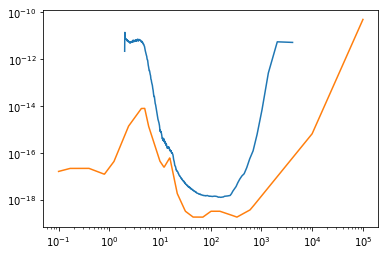

TRIS


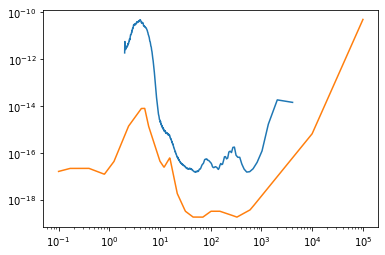

ERM


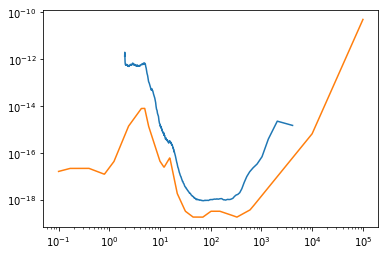

WVT


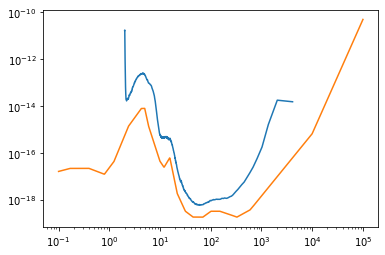

KDAK


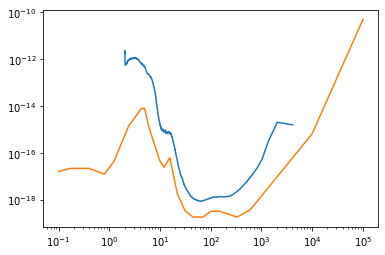

NWAO


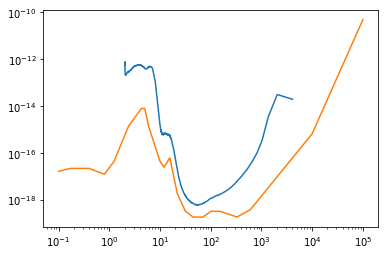

SSB


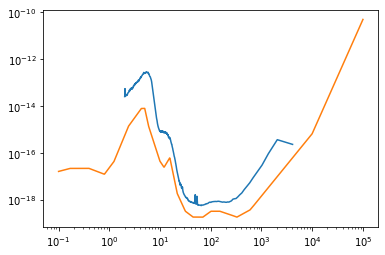

INCN


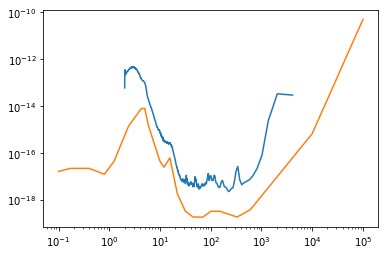

BORG


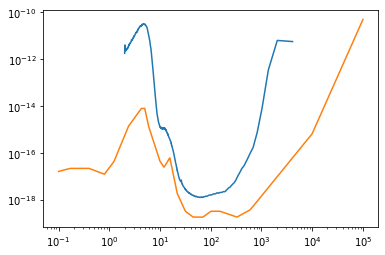

ESK


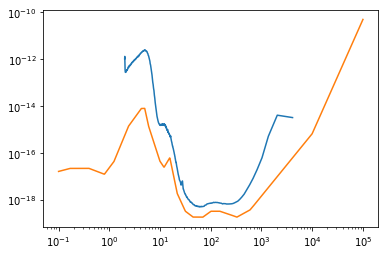

ALE


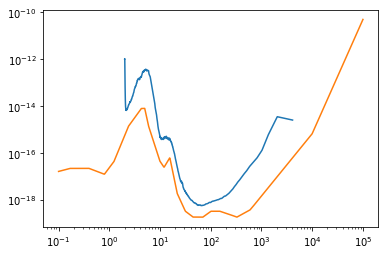

RSSD


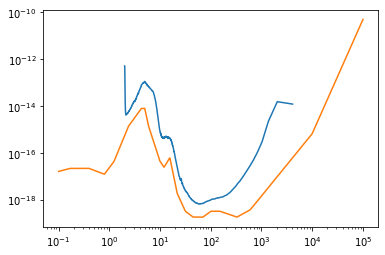

CMLA


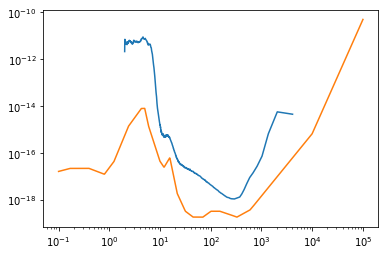

FURI


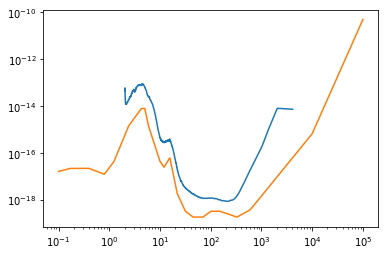

SIMI


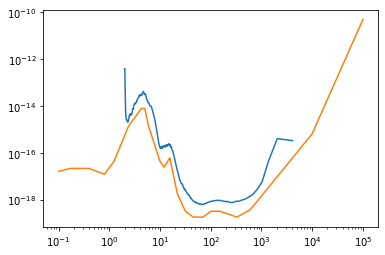

SNZO


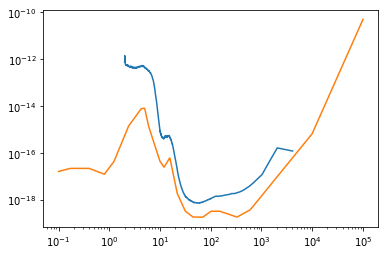

MAJO


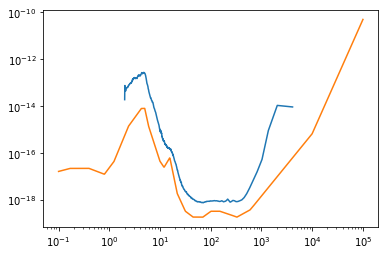

SJG


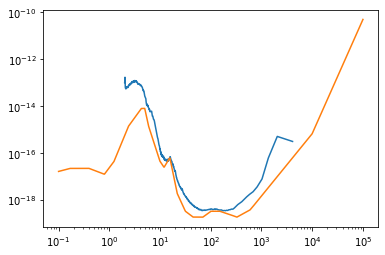

HOPE


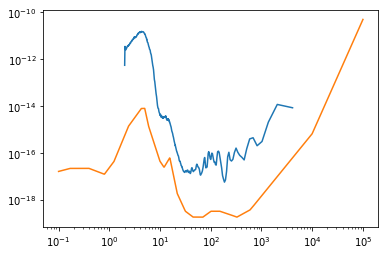

MPG


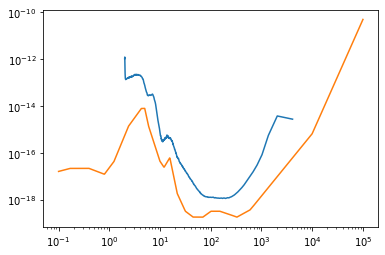

RCBR


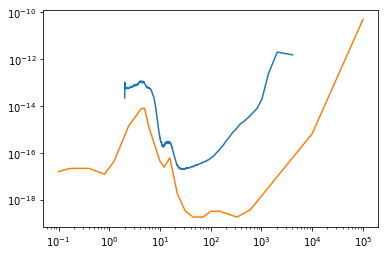

KBS


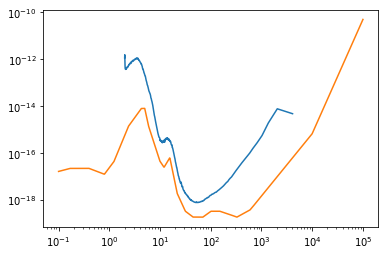

LCO


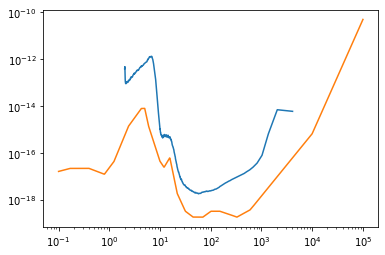

MSVF


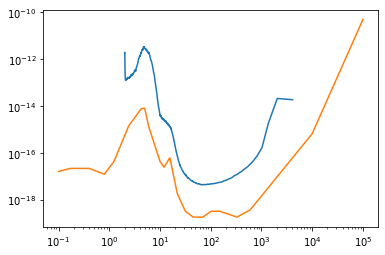

FDF


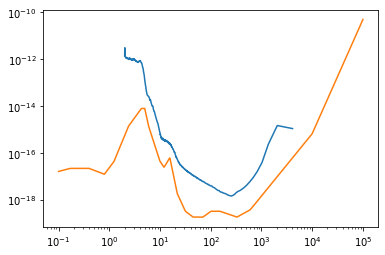

POHA


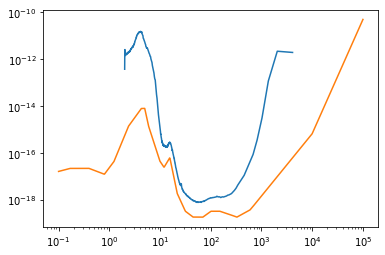

NIL


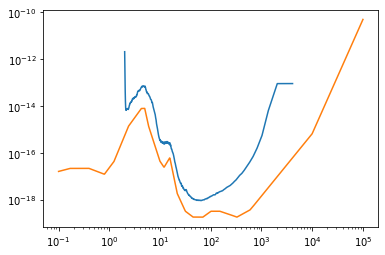

ARU


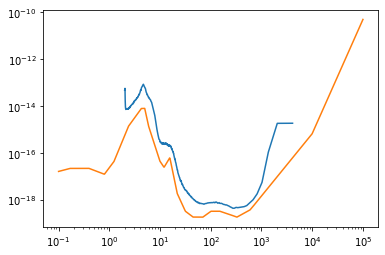

PET


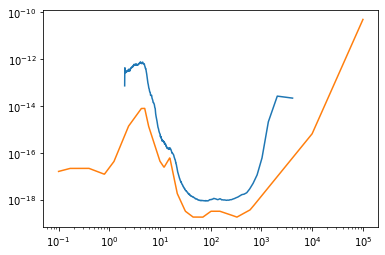

YAK


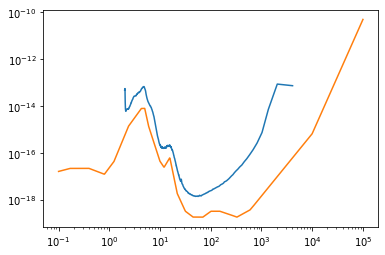

RAR


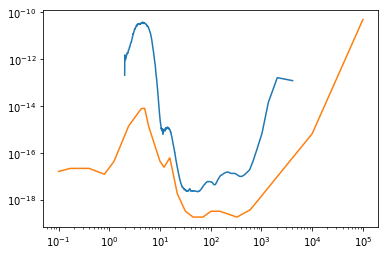

PAF


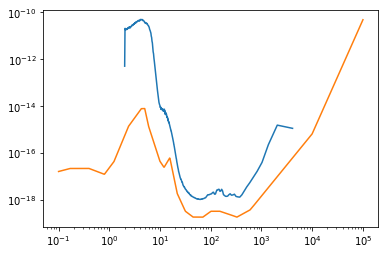

KURK


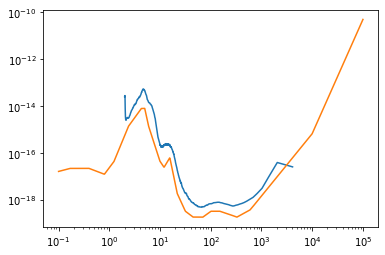

ANMO


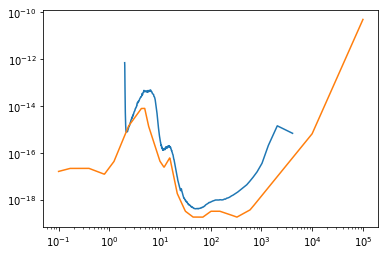

SHEL


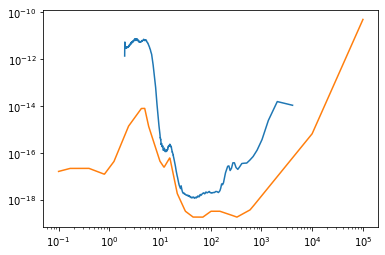

PTCN


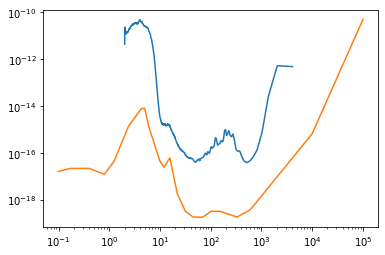

DWPF


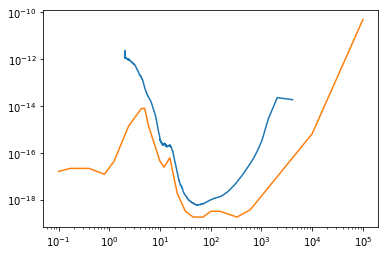

CTAO


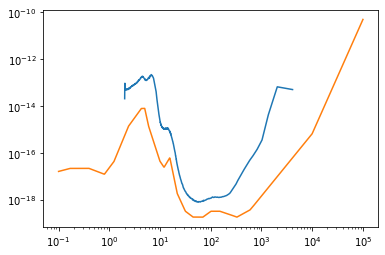

LSZ


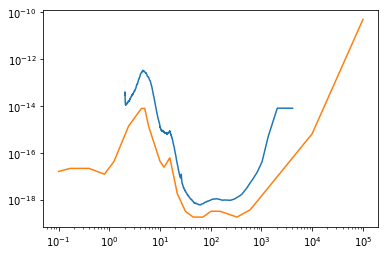

HKT


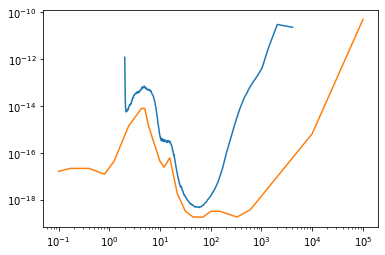

KIP


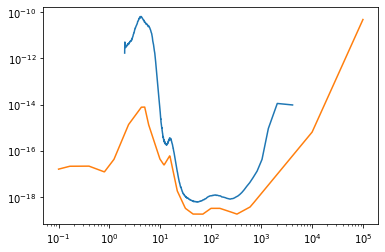

ANTO


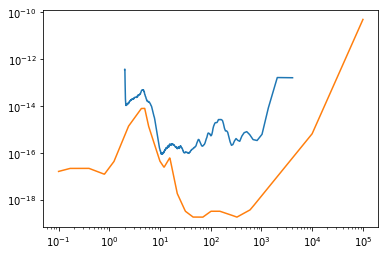

DRV


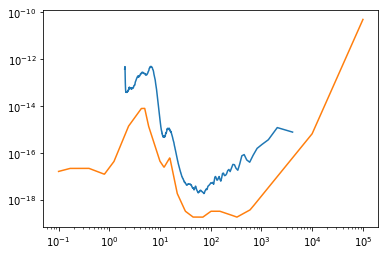

CASY


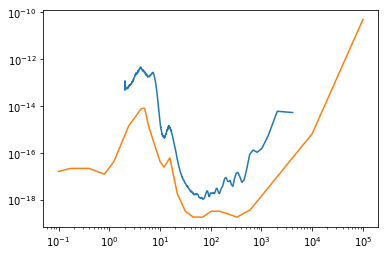

CCD


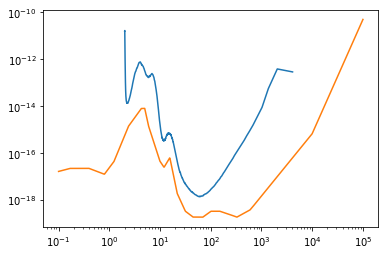

ADK


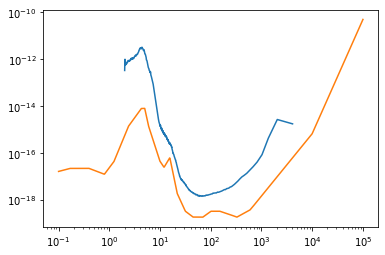

KIV


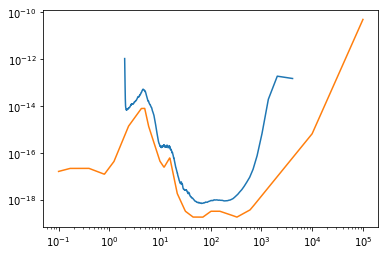

NOUC


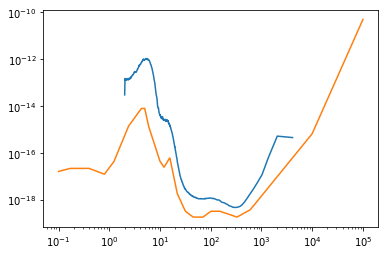

TUC


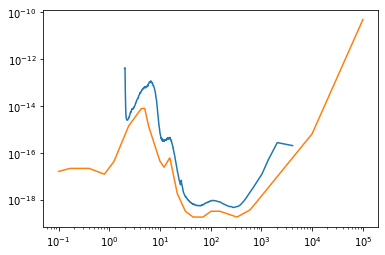

KWJN


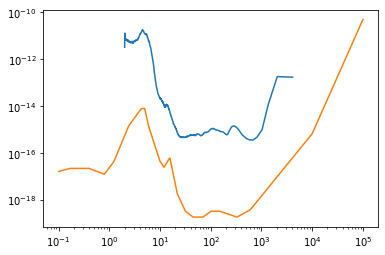

OBN


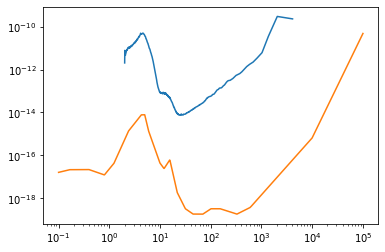

PFO


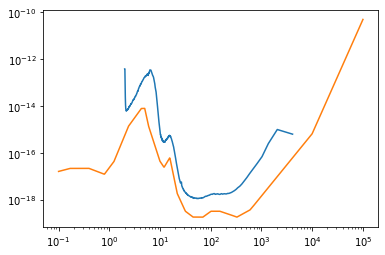

TSUM


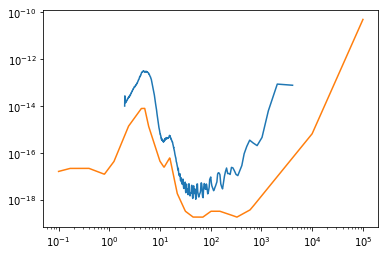

BRVK


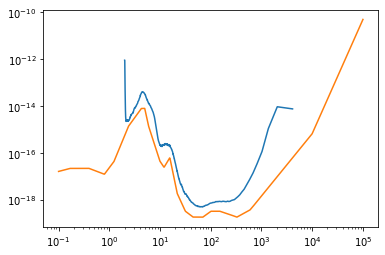

MBWA


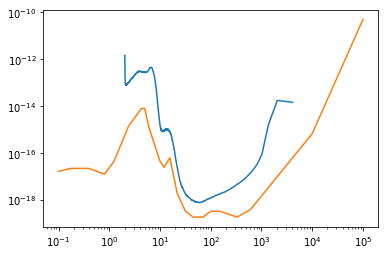

SACV


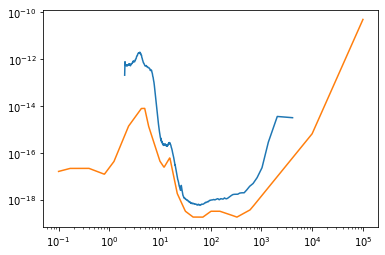

MSEY


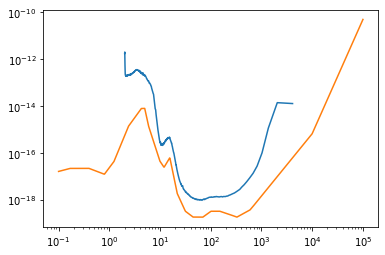

NNA


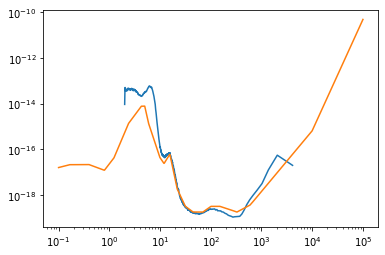

AAK


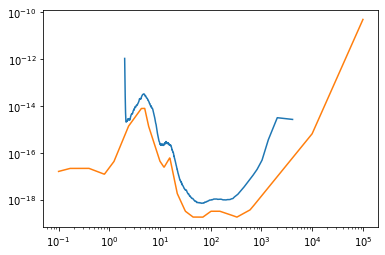

CLF


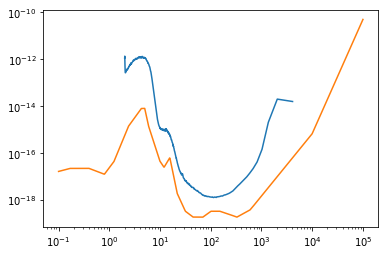

WUS


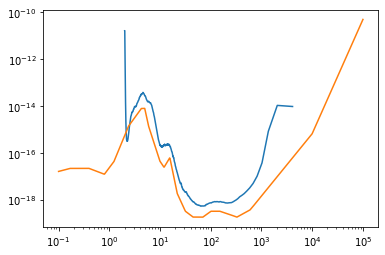

YSS


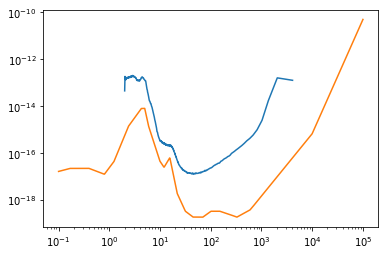

LVC


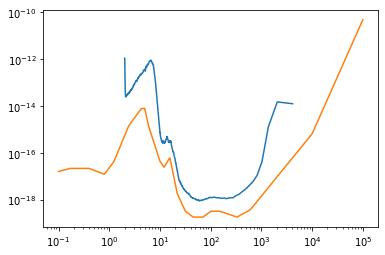

PALK


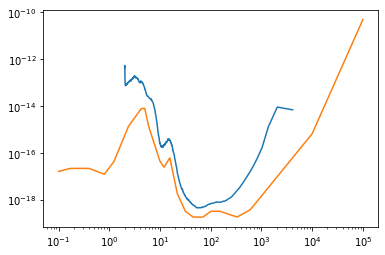

BFO


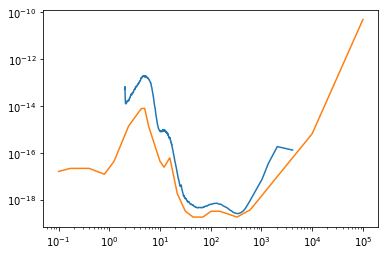

ECH


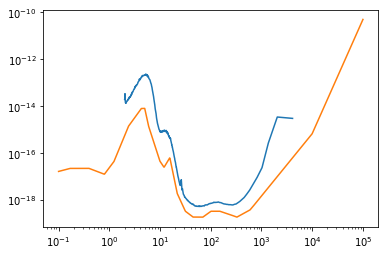

WCI


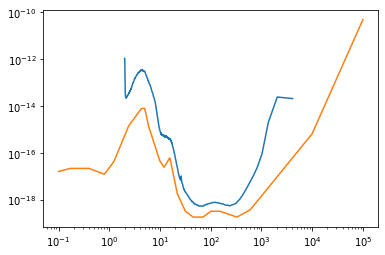

COYC


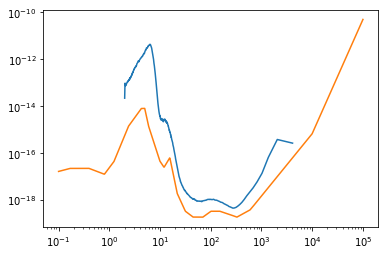

ABPO


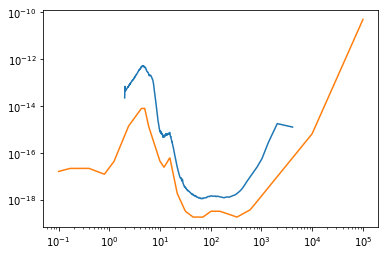

COR


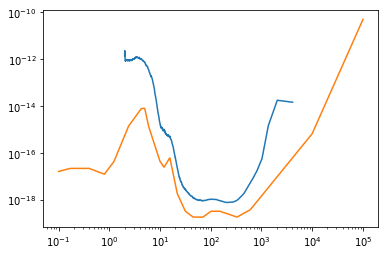

KIEV


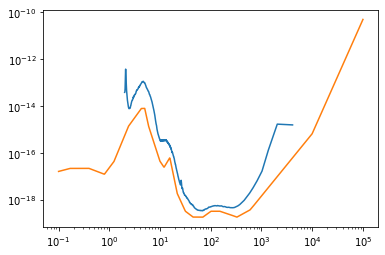

RAYN


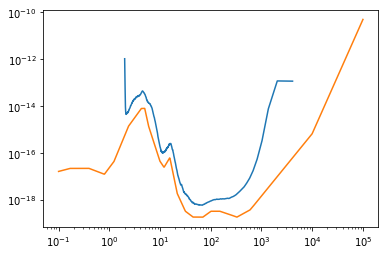

ASCN


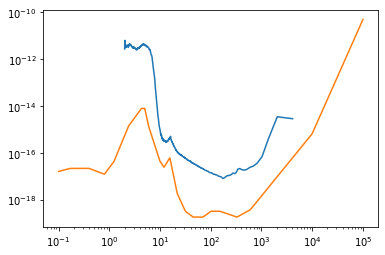

HNR


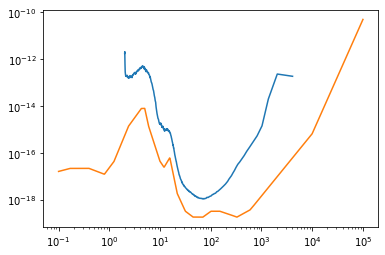

BBSR


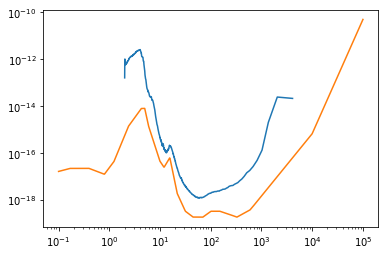

ROCAM


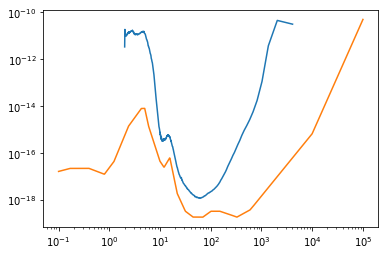

PAYG


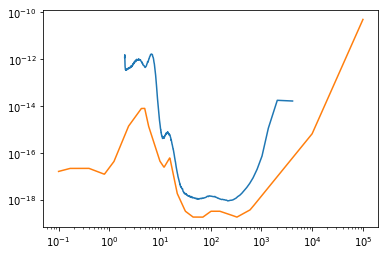

ULN


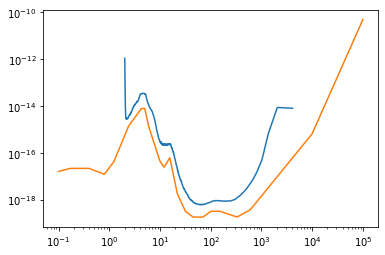

SUR


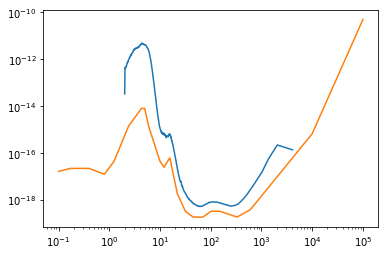

PMSA


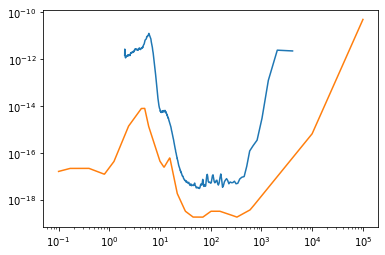

FOMA


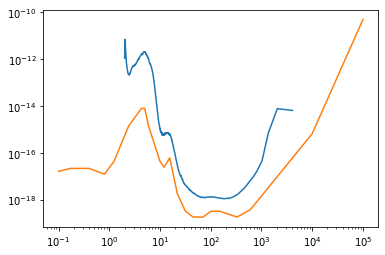

HDC


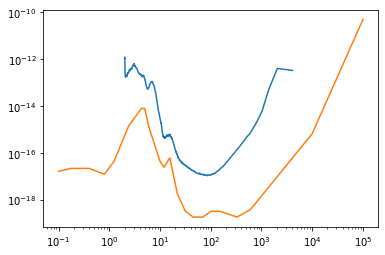

KEV


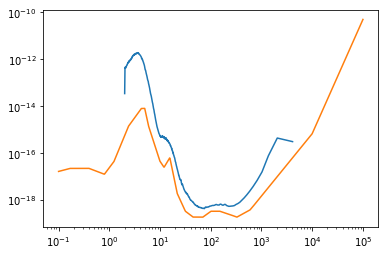

LVZ


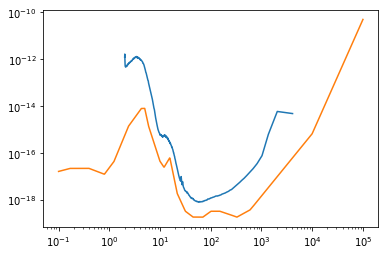

PEL


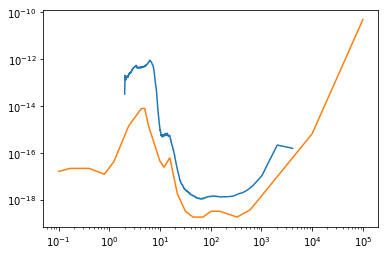

MIDW


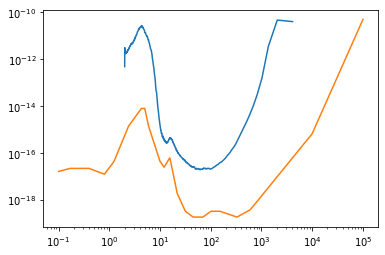

DGAR


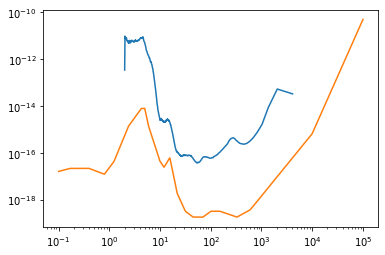

FUTU


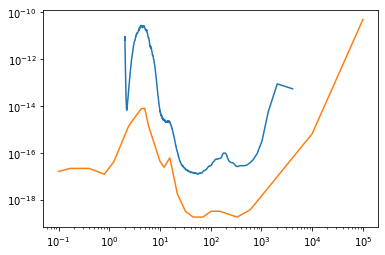

SDV


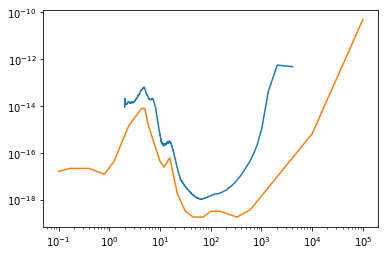

SPB


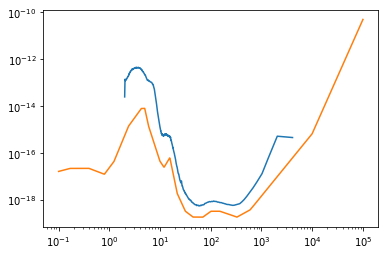

UOSS


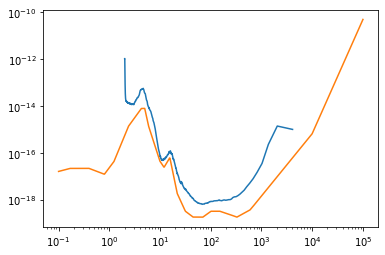

DAV


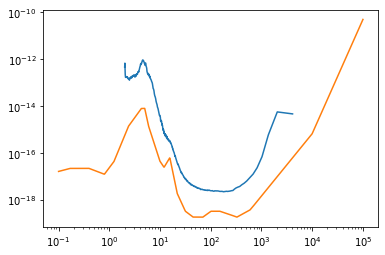

BILL


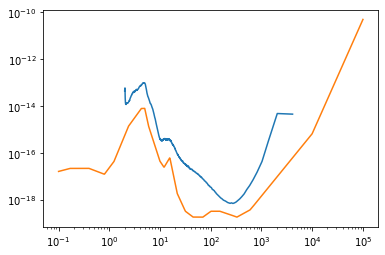

GRFO


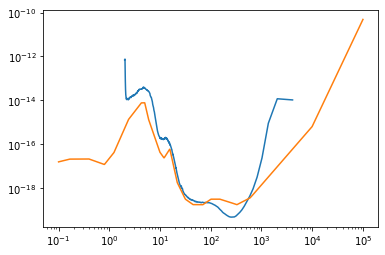

RAO


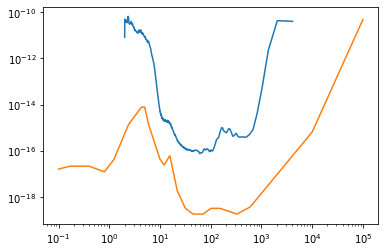

SANVU


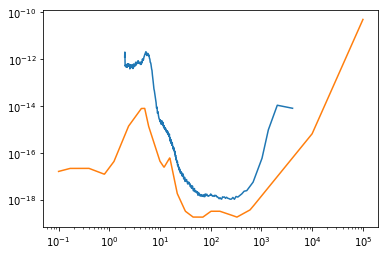

TAM


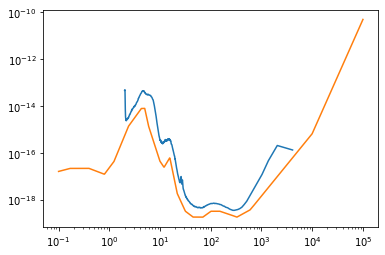

ATD


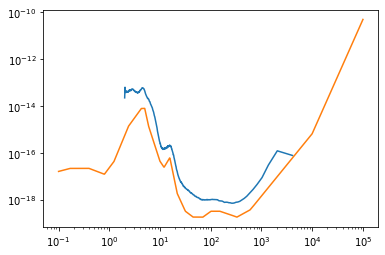

INU


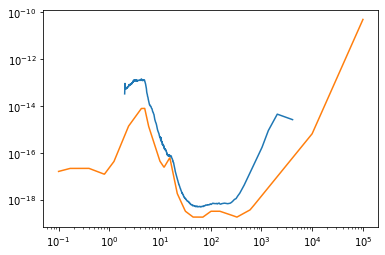

MBAR


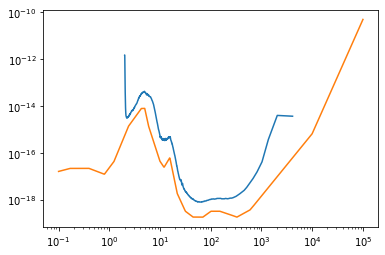

TEIG


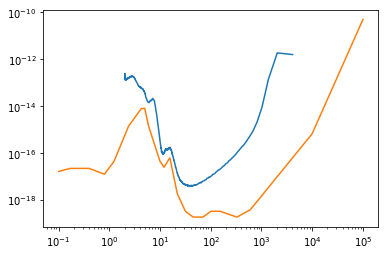

CAN


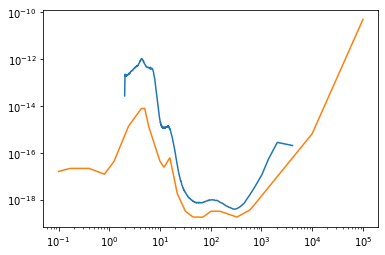

GNI


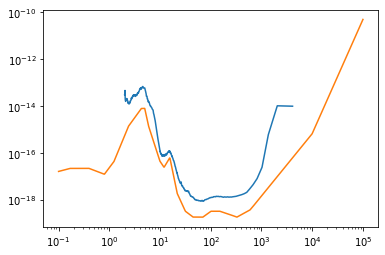

CRZF


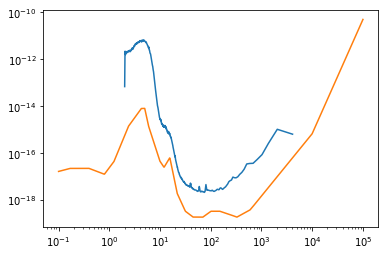

RER


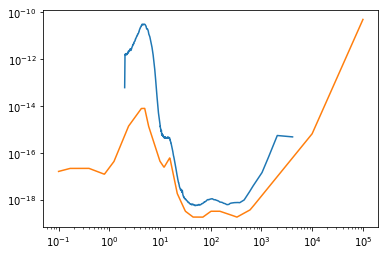

OTAV


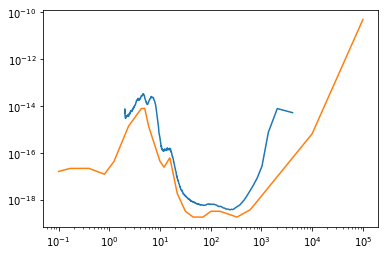

WRAB


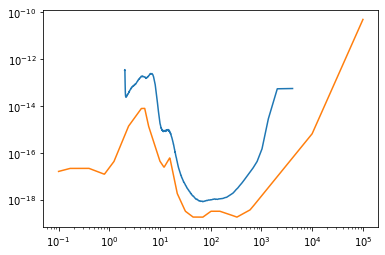

IVI


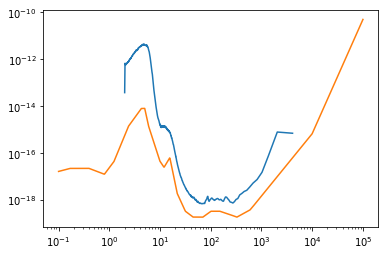

PPTF


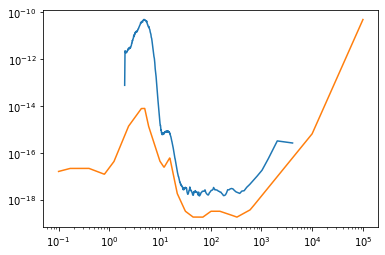

SBA


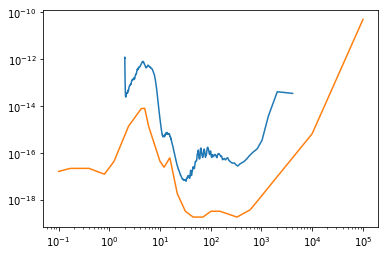

AIS


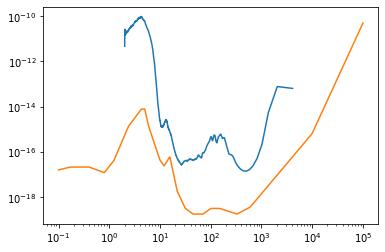

In [61]:
# tmp = np.load(config['noise_models'])
# nm_periods, nlnm, nhnm = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp



# for sta in sta_med.keys():
#     if sta is not 'period' and sta.split(".")[0] not in config['excluded_stations']:
#         print(sta)
#         plt.loglog(sta_med['period'], sta_med[sta])
#         plt.loglog(nm_periods, 10**(nlnm/10))
#         plt.show();